In [136]:

import os
import sys
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk.corpus
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
nltk.download('stopwords')
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/mgdielman/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Project Topic #
This project is investigating the ability to determine the author of an article from the raw text of the article. We will be using three types of supervised learning models to attempt to classify the articles by author, a Support Vector Machine, a Decision Tree, and a Random Forest extension of the Decision Tree model.

Topic classification is a common problem in machine learning, where text is analyzed for keywords that can identify the subject matter of the article, however we expect that author classification will provide extra difficulty as the typical vectorization removes punctuation and stop words that have limited value in topic determination. Those stop words and punctuation might be valuable for identifying author style however.

Author identification has a number of interesting applications. For historians it is a significant area of research to identify whether an unknown author of a manuscript or draft is known for other works, and pseudonyms often make it difficult to trace authorship. Famously the question was raised of whether all of Shakespeare's works are his own. For modern applications an effective way to determine authorship is used in forensic lingustics for determining if confessions, threats, and other documents can be attributed to an individual and is used by police and the military.

# Data #
The data used for this project is the Reuters 50 50 dataset which contains 100 text file copies articles by each of 50 Reuters authors. The data comes split 50/50 into train and test subdirectories, but those were combined for this test so that a custom train test split can be generated. The data is loaded below into two columns, author, which contains the directory name of the author, and the text, which contains the content of the raw text files.

The data is available under a Creative Commons Attribution 4.0 Internation license and can be accessed at https://archive.ics.uci.edu/dataset/217/reuter+50+50.

<p style="text-align: center;">References</p>

Liu,Zhi. (2011). Reuter_50_50. UCI Machine Learning Repository. https://doi.org/10.24432/C5DS42.

# Data Cleaning #
The dataset used is provided starting in a mostly clean state, there are no null values for articles and the size and balance of the data categories are known to be balanced by the nature of the dataset. However there is some routine cleaning we need to perform for Natural Language Processing.

Step 1: We load the data file by file into arrays, as it is provided in a non-tabular format. The arrays are then converted into a dataframe with two columns (author and text) and 5000 rows (50 authors with 100 articles each)

Step 2: Any non-alphanumeric characters are removed, as we do not want to consider, for example, "International" to be treated differently from "International,"

Step 3: Stop words are removed, and a stemmer is applied. This reduces the number of probably insignificant features as stop words like "as" or "and" are typically not easily distinguishable between articles. The stemmer combines features with similar roots, like "run", "running", and "runner" which likely have similar meaning in articles.

Step 4: We present a set of the most and least frequently used words  to check for any outliers. In the most frequently used words there are some words that could possibly be considered stopwords like "said" and "new" but it is not clear that they have little value and since we have reduced to 40,000 unique words we will not manually exclude them. There are some issues on the infrequently used words. We observe that while most of the infrequent words are just uncommon terms, some are misspellings or missed spaces. Unfortunately it is not clear that there is an effective way to algorithmically eliminate these words from slang or hyphenated terms, so for this analysis we will leave them. If we had the resources to manually read and correct the documents that would be ideal.

Step 5: Histograms are shown of the frequencies of words in all articles, and the lengths of the articles. We note that there are many more singleton or infrequent words than common words, as would be expected. However these specific words are likely the most valuable predictively, and the article lengths are approximately normally distributed so there is not further data cleaning we perform.

Step 6: In order to work with the text, we convert the remaining words to a matrix of word counts. We are using a TF-IDF vectorizer for this conversion, which accounts for the relative frequency of the word in a single document to the frequency of the word in all documents. This way highly specific terms are weighted more highly when they appear.

In [2]:
#Loads data from .txt files
y_array = []
x_array = []
for directory in os.listdir('Reuters Data'):
    author = directory
    for file in os.listdir('Reuters Data/'+author):
        file_name = os.path.join('Reuters Data/'+author, file)
        file_content = open(file_name)
        y_array.append(author)
        x_array.append(file_content.read())
        file_content.close()

dictionary = {'author':y_array, 'text':x_array}
df = pd.DataFrame(dictionary)
print(df)

          author                                               text
0      NickLouth  Hordes of aggressive telephone resellers bangi...
1      NickLouth  AT&amp;T Corp. on Wednesday said basic U.S. ra...
2      NickLouth  The $25 billion cable TV industry, once consid...
3      NickLouth  Citizens Utilities Co said on Thursday that it...
4      NickLouth  Worries about regulatory hurdles and a lengthy...
...          ...                                                ...
4995  TimFarrand  London Clubs International, which runs the Lon...
4996  TimFarrand  David Jones, chief executive of British fashio...
4997  TimFarrand  Tobacco to insurance group B.A.T Industries Pl...
4998  TimFarrand  Ice cream had a sad time in Europe this summer...
4999  TimFarrand  Imperial Tobacco Group Plc, demerged from Hans...

[5000 rows x 2 columns]


In [3]:
#Regex replaces non alphanumeric with empty strings
meaning_df = df.copy()
meaning_df['text'] = df['text'].str.replace('[^a-zA-Z\d\s]','', regex=True)
print(meaning_df)

          author                                               text
0      NickLouth  Hordes of aggressive telephone resellers bangi...
1      NickLouth  ATampT Corp on Wednesday said basic US rates f...
2      NickLouth  The 25 billion cable TV industry once consider...
3      NickLouth  Citizens Utilities Co said on Thursday that it...
4      NickLouth  Worries about regulatory hurdles and a lengthy...
...          ...                                                ...
4995  TimFarrand  London Clubs International which runs the Lond...
4996  TimFarrand  David Jones chief executive of British fashion...
4997  TimFarrand  Tobacco to insurance group BAT Industries Plc ...
4998  TimFarrand  Ice cream had a sad time in Europe this summer...
4999  TimFarrand  Imperial Tobacco Group Plc demerged from Hanso...

[5000 rows x 2 columns]


In [4]:
#Apply Stemmer to generalize tenses, and remove stopwords
stemmer = PorterStemmer()
stops = stopwords.words('english')
meaning_df['text'] = meaning_df['text'].apply(lambda x: ' '.join([text for text in x.split() if text not in (stops)]))
meaning_df['text'] = meaning_df['text'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))
print(meaning_df)
words = meaning_df['text'].str.split()
article_lengths = meaning_df['text'].str.len()
#Explode gives all words from all authors as a single series
words = words.explode()
word_frequencies = words.value_counts()
print(word_frequencies.head(10))
print(word_frequencies.tail(10))
print(word_frequencies.shape)

          author                                               text
0      NickLouth  hord aggress telephon resel bang gate atampt c...
1      NickLouth  atampt corp wednesday said basic us rate state...
2      NickLouth  the 25 billion cabl tv industri consid major t...
3      NickLouth  citizen util co said thursday aim among larges...
4      NickLouth  worri regulatori hurdl lengthi 12 month comple...
...          ...                                                ...
4995  TimFarrand  london club intern run london ritz le ambassad...
4996  TimFarrand  david jone chief execut british fashion retail...
4997  TimFarrand  tobacco insur group bat industri plc wednesday...
4998  TimFarrand  ice cream sad time europ summer ad fresh impet...
4999  TimFarrand  imperi tobacco group plc demerg hanson plc oct...

[5000 rows x 2 columns]
text
said       39973
the        17960
year       12114
compani    10989
percent    10759
would      10260
million    10002
market      9193
analyst     7821
n

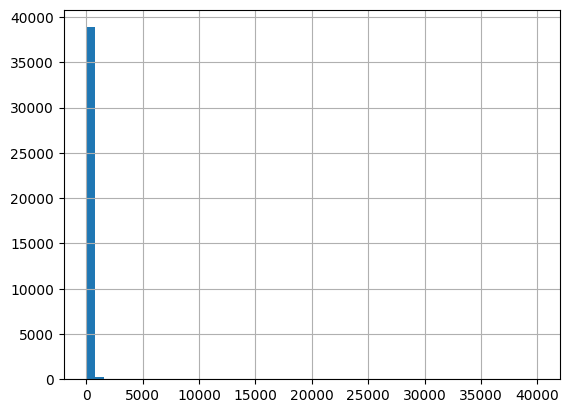

In [5]:
frequencies = word_frequencies.hist(bins=50)

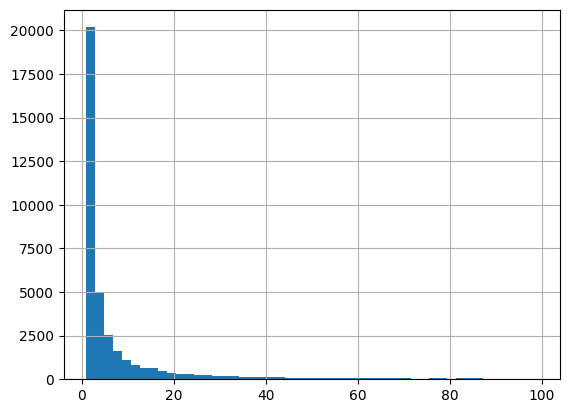

In [6]:
frequencies = word_frequencies[word_frequencies<100].hist(bins=50)

<Axes: >

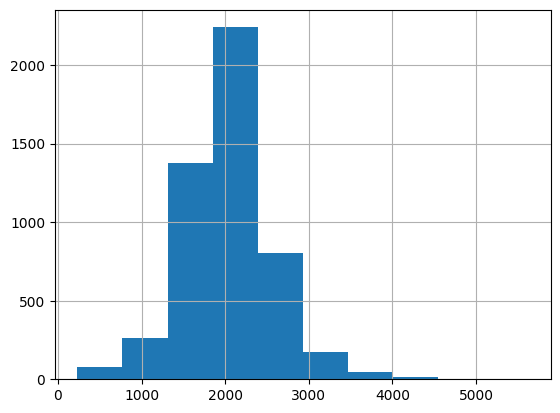

In [7]:
article_lengths.hist()

In [22]:
#Apply Vectorizer
vectorizer = TfidfVectorizer()
meaning_X = meaning_df['text']
meaning_X = vectorizer.fit_transform(meaning_X)
meaning_y = meaning_df['author']

# Exploratory Data Analysis #
We first print plots of the top 5 words per author per their total words, and notice that again "said" amd "the" have limited value to this analysis, so we might be able to consider them as stopwords in the future. However most other top words are not frequently shared, and TF-IDF will already weight "said" and "the" lower due to them being shared between documents so our initial data structure looks to be variable enough across authors that word frequency will be able to function.

One concern, as discussed in the problem statement, is that we have lost most of the stylistic elements to the analysis. We can predict based on word choice but will largely be grouping by subject matter written about. To look into this further we generate a heatmap of the cosine similarity between authors, and look specifically at some of the areas on the heatmap with high similarity. Take for example Jane Macartney and Benjamin Kang Lim, they have a high similarity and we observe that they both have China as a top word, with other words related to China like beij, which is likely a stemmed Beijing. So these authors may be frequently confused because their word choice is dictated not by author style, but by subject matter.

This is a double edged sword for this analysis - our predictive capability will be improved by the fact that authors can be distinguished by subject matter, but expect to see many errors between these two authors when we generate our confusion matrix from our models. Improvements to the model to distinguish between authors with similar subject matter will be an interesting future project.

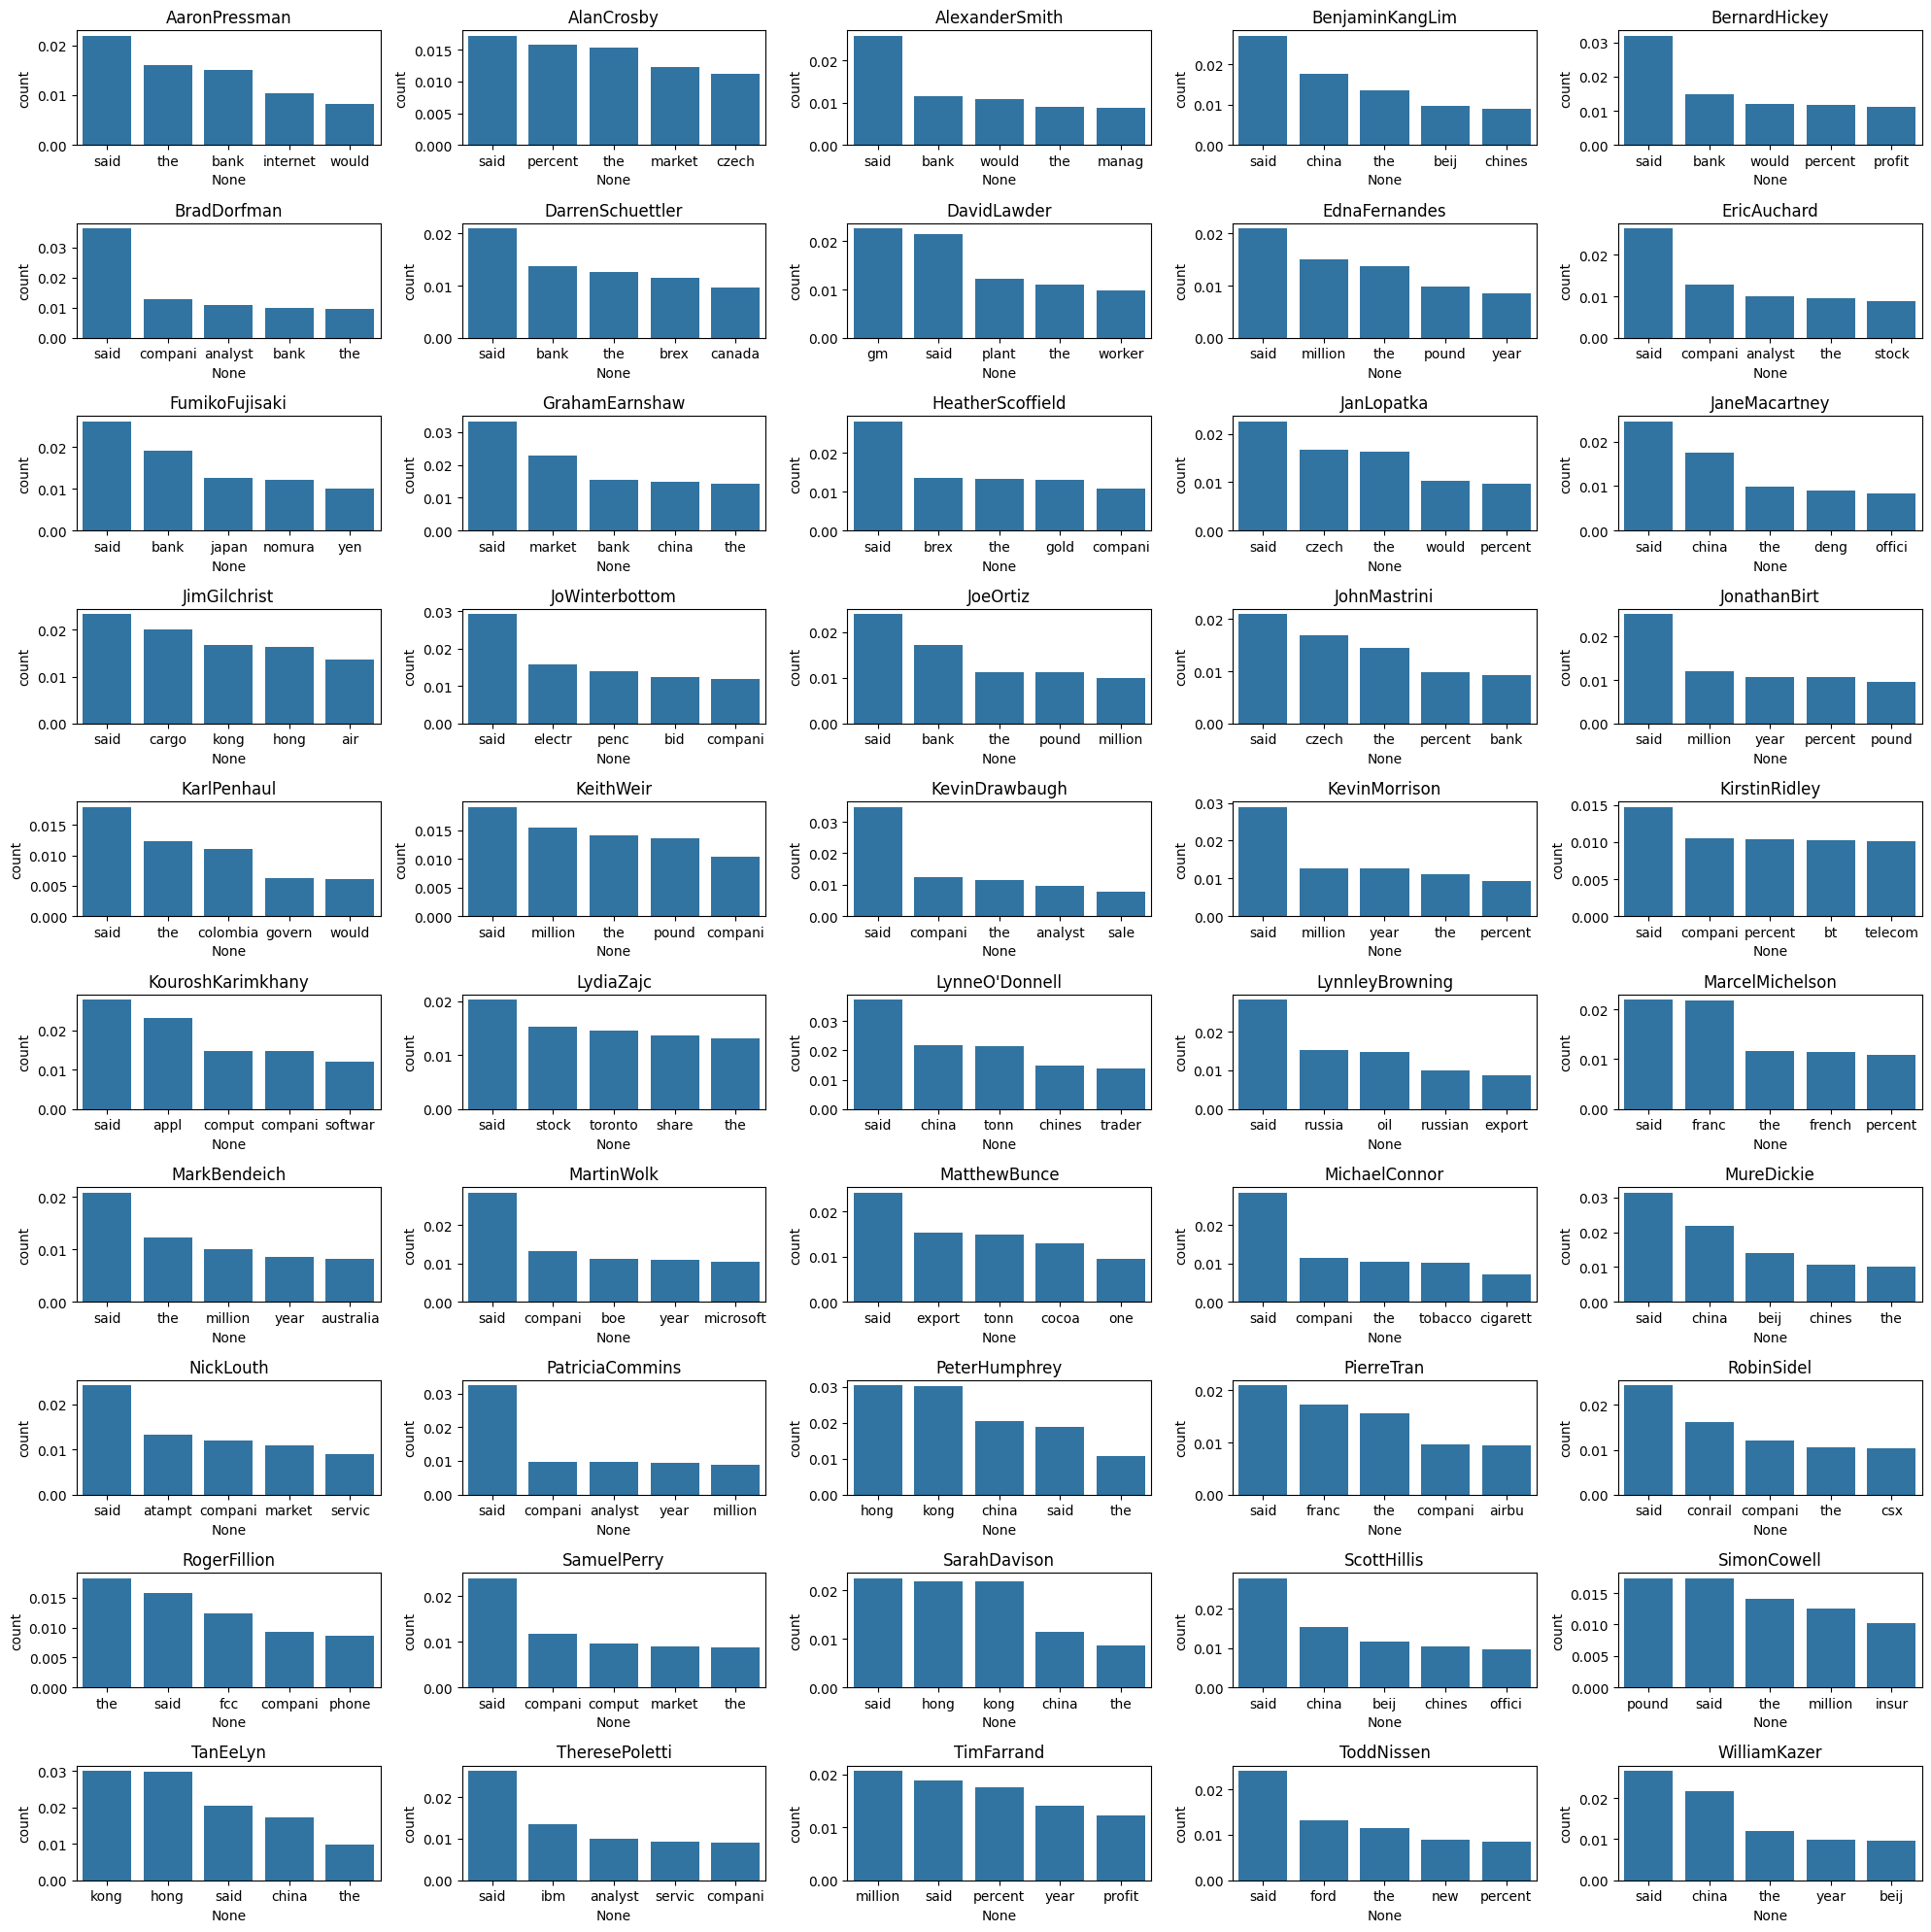

In [118]:
#Generating graphs of most common words by author
vectorized_df = pd.DataFrame(meaning_X.toarray())
vectorized_df = vectorized_df.set_index(meaning_y)
agg_df = vectorized_df.groupby('author').sum()

count_df = meaning_df.groupby(['author'], as_index=False).agg({'text': ' '.join})
count_df['text'] = count_df['text'].str.split()

fig, axes = plt.subplots(10,5, figsize=(20, 20))
plot_number = 0
for index, text in count_df.iterrows():
    word_series = pd.Series(text['text'])
    relative_frequency = (word_series.value_counts()/word_series.count())
    relative_frequency = relative_frequency.head()
    sns.barplot(x=relative_frequency.index, y=relative_frequency, ax=axes[int(plot_number/5), plot_number%5])
    axes[int(plot_number/5), plot_number%5].set_title(text['author'])
    plot_number += 1
fig.tight_layout()
plt.show()

In [112]:
#Similarity matrix uses built in pairwise similarity functionality
similarity = cosine_similarity(agg_df)

<Axes: >

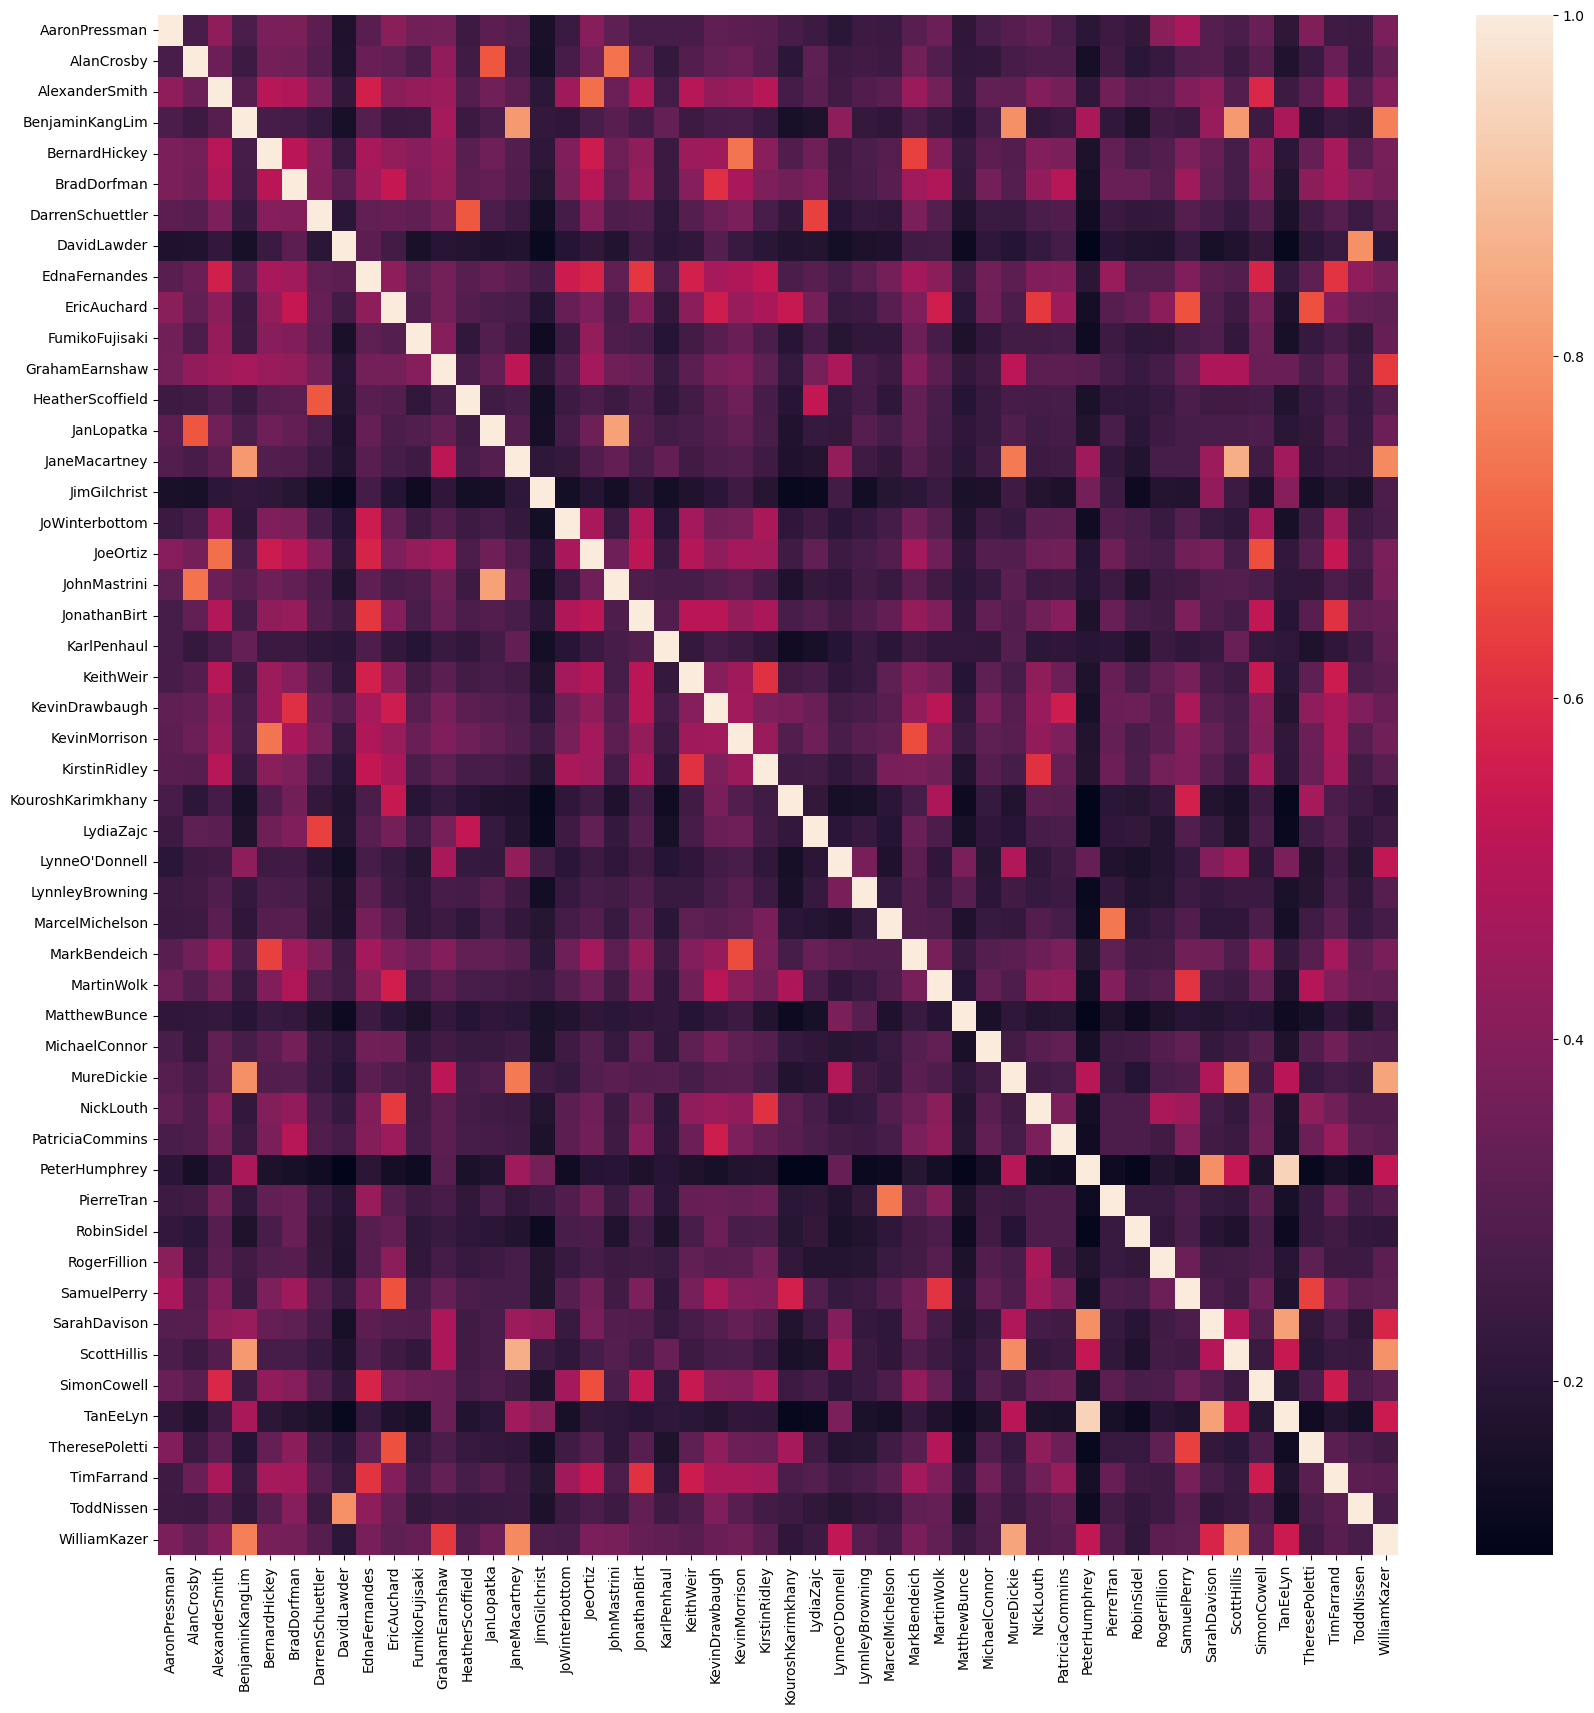

In [113]:
plt.figure(figsize=(20, 20))
sns.heatmap(similarity, xticklabels=agg_df.index, yticklabels=agg_df.index)

# Models #
The main concerns we have when working with this data are the large dimensionality associated with NLP, as each unique word becomes its own feature vector, and colinearity between the featue vectors. While we could not run full analysis of colinearity due to the size of the feature set, we would anticipate that there would be many words used only in the same contexts that would introduce colinearity. Our choice of two classification models that handle those constraints well are Support Vector Machines and Random Forest.

Support Vector Machines: Support vector machines use built in regularization through the C parameter, which should already limit the impact of colinearity.

Random Forests: Random forests avoid the colinearity issue because they decide on exactly one feature per step, so if two features are colinear the random forest can simply select one to use. Additionally they avoid overfitting due to dimensionality be choosing only a subset of dimensions to decide on in each decision tree in the random forest.

Decision Tree: We would expect decision trees to perform poorly due to the above issues, and have included one as a baseline comparison.

Hyperparameters were determined using cross validation through GridSearchCV, some values are shown here, but due to runtime constraints on the models the full search involved using subsets of hyperparameters and adjusting the range if the maximum was found to be optimal. Only the final grid search that returned optimal parameters are shown below.

In [171]:
#Train test split
meaning_X_train, meaning_X_test, meaning_y_train, meaning_y_test = train_test_split(meaning_X, meaning_y, stratify=meaning_y)

In [172]:
#Support Vector Model
svc_grid = {'C': [16, 8, 4],
        'gamma': [1]
}
svc_grid_search = GridSearchCV(SVC(), svc_grid)
svc_grid_search.fit(meaning_X_train, meaning_y_train)
svc_grid_search.best_params_

{'C': 8, 'gamma': 1}

In [173]:
svc_model = SVC(C=4, gamma=1)
svc_model.fit(meaning_X_train, meaning_y_train)

SVC(C=4, gamma=1)

In [174]:
svc_train_predictions = svc_model.predict(meaning_X_train)
svc_test_predictions = svc_model.predict(meaning_X_test)
svc_train_accuracy = accuracy_score(meaning_y_train, svc_train_predictions)
svc_test_accuracy = accuracy_score(meaning_y_test, svc_test_predictions)
print(svc_train_accuracy)
print(svc_test_accuracy)

0.9997333333333334
0.828


In [175]:
#Decision Tree Model
dt_grid = {'max_depth': [2, 4, 8, 16],
        'ccp_alpha': [0.01, 0.1, 1]
}
dt_grid_search = GridSearchCV(DecisionTreeClassifier(), dt_grid)
dt_grid_search.fit(meaning_X_train, meaning_y_train)
dt_grid_search.best_params_

{'ccp_alpha': 0.01, 'max_depth': 16}

In [176]:
dt_model = DecisionTreeClassifier(ccp_alpha = 0.01, max_depth = 16)
dt_model.fit(meaning_X_train, meaning_y_train)

DecisionTreeClassifier(ccp_alpha=0.01, max_depth=16)

In [177]:
dt_train_predictions = dt_model.predict(meaning_X_train)
dt_test_predictions = dt_model.predict(meaning_X_test)
dt_train_accuracy = accuracy_score(meaning_y_train, dt_train_predictions)
dt_test_accuracy = accuracy_score(meaning_y_test, dt_test_predictions)
print(dt_train_accuracy)
print(dt_test_accuracy)

0.29413333333333336
0.288


In [178]:
#Random Forest Model
rf_grid = {'n_estimators': [50, 100, 200, 400],
'max_depth': [5, 10, 15, 20],
'max_features': ['sqrt','log2']
}
rf_grid_search = GridSearchCV(RandomForestClassifier(), rf_grid)
rf_grid_search.fit(meaning_X_train, meaning_y_train)
rf_grid_search.best_params_

{'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 400}

In [179]:
rf_model = RandomForestClassifier(n_estimators=400, max_depth=20, max_features='sqrt')
rf_model.fit(meaning_X_train, meaning_y_train)

RandomForestClassifier(max_depth=20, n_estimators=400)

In [180]:
rf_train_predictions = rf_model.predict(meaning_X_train)
rf_test_predictions = rf_model.predict(meaning_X_test)
rf_train_accuracy = accuracy_score(meaning_y_train, rf_train_predictions)
rf_test_accuracy = accuracy_score(meaning_y_test, rf_test_predictions)
print(rf_train_accuracy)
print(rf_test_accuracy)

0.9994666666666666
0.7752


# Results and Analysis #

Of the two models we expected to be effective, we see similar results. Both achieved greater than 99.9% train accuracy, which should be an effective measure here as we designed our datasets to be balanced. The differentiation comes at the test accuracy, where we see that the Random Forest model only achieved 76.32% accuracy, while the Support Vector Machine achieved 82.88% accuracy.

Confusion matrices are shown below, where we see that in both cases the confusion matrix has misclassified values where our similarity matrix above showed that authors had similar subjects. Looking into these authors we again see that most of the confusion comes when they write on similar topics. In hope of better identifying style, we consider using ngrams, as phrases with multiple words may be able to capture an author's style more than just their vocabulary. This iteration uses the same model we produced for the SVC analysis, but we add ngrams to our vectorizer. We experimented with several ngram lengths, and found an ngram length of 3 produced the best test results, with an improvement to 84.48% test accuracy.

                        Train Accuracy  Test Accuracy
Decision Tree                 0.294133         0.2880
Random Forest                 0.999467         0.7752
Support Vector Machine        0.999733         0.8280


<Axes: >

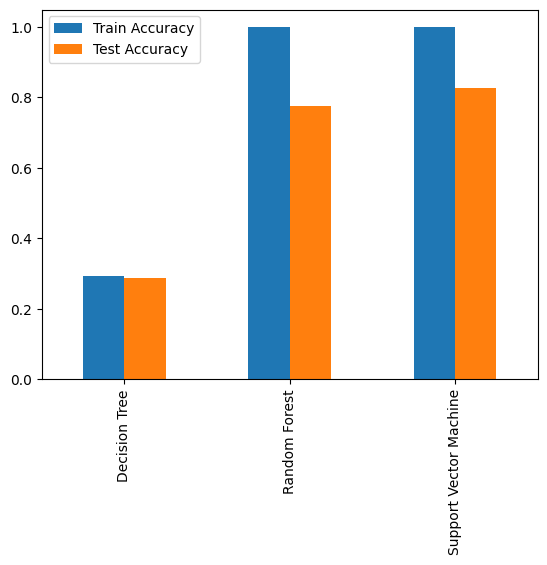

In [181]:
acc_dict = {'Train Accuracy': [dt_train_accuracy, rf_train_accuracy, svc_train_accuracy],
            'Test Accuracy': [dt_test_accuracy, rf_test_accuracy, svc_test_accuracy]}
acc_index = ['Decision Tree','Random Forest','Support Vector Machine']
results_df = pd.DataFrame(acc_dict, index=acc_index)
print(results_df)
results_df.plot.bar()

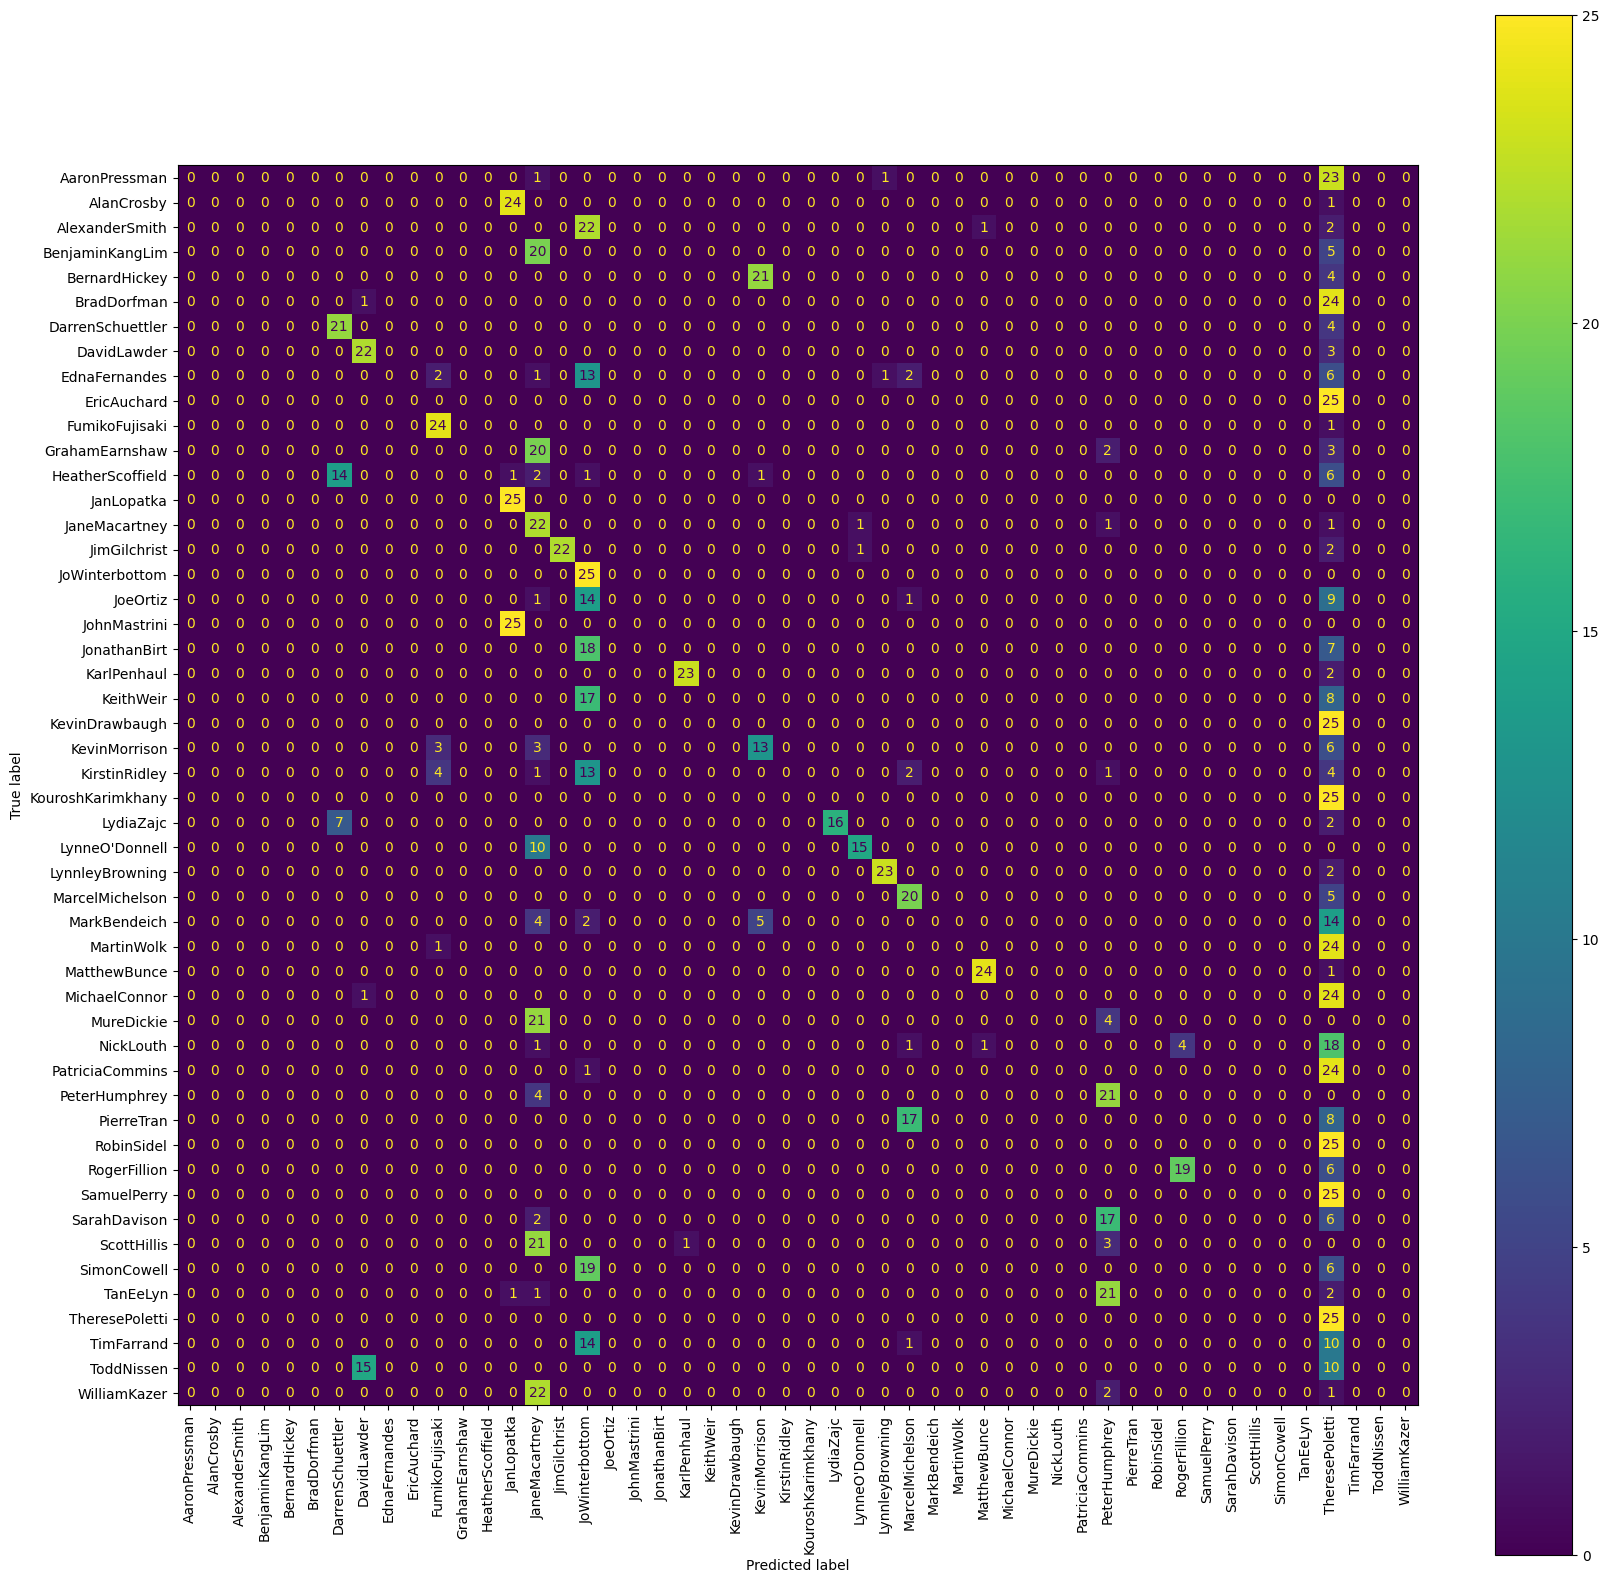

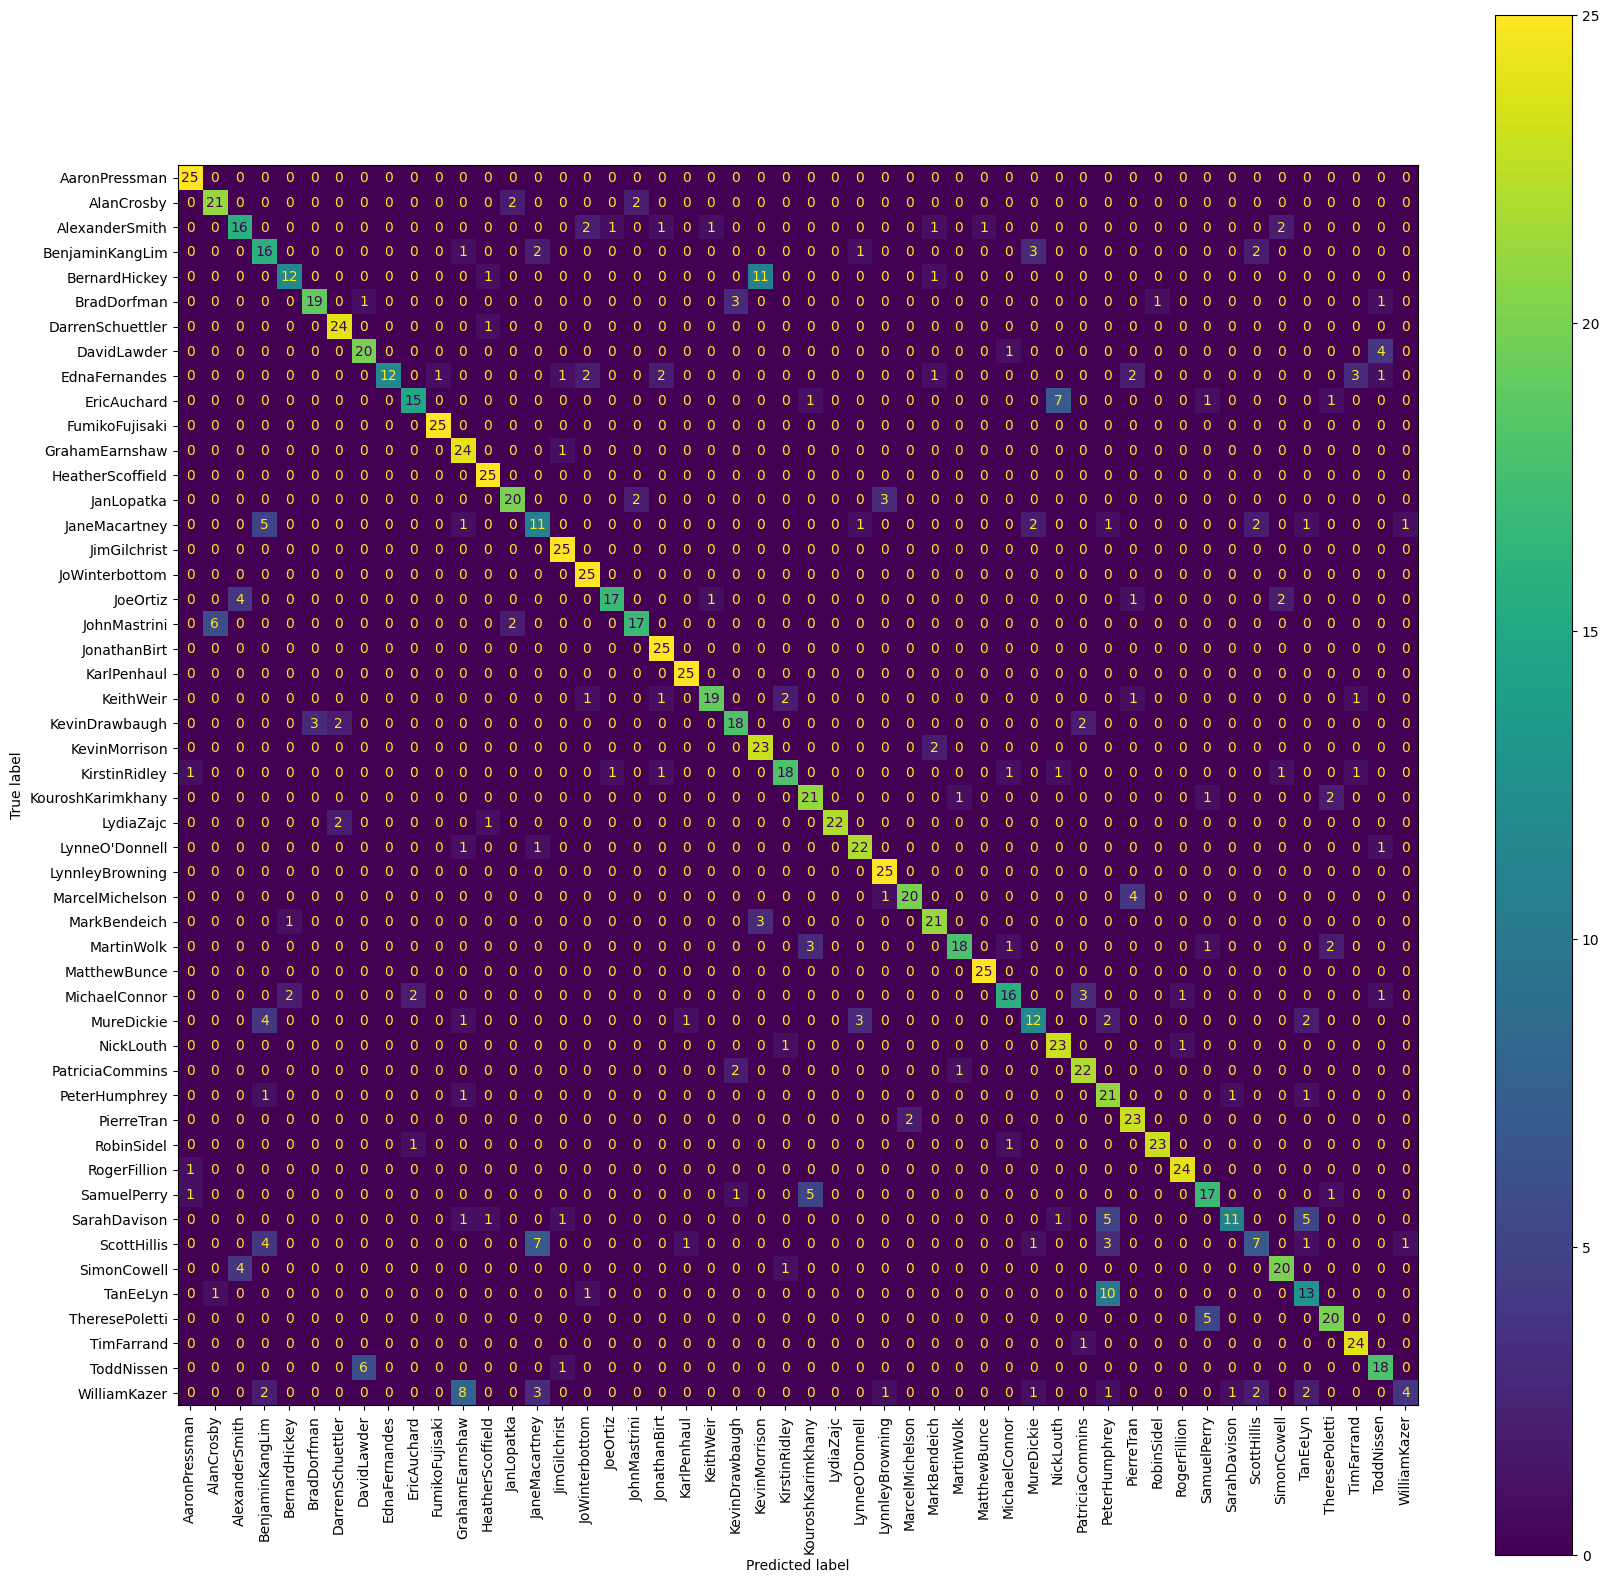

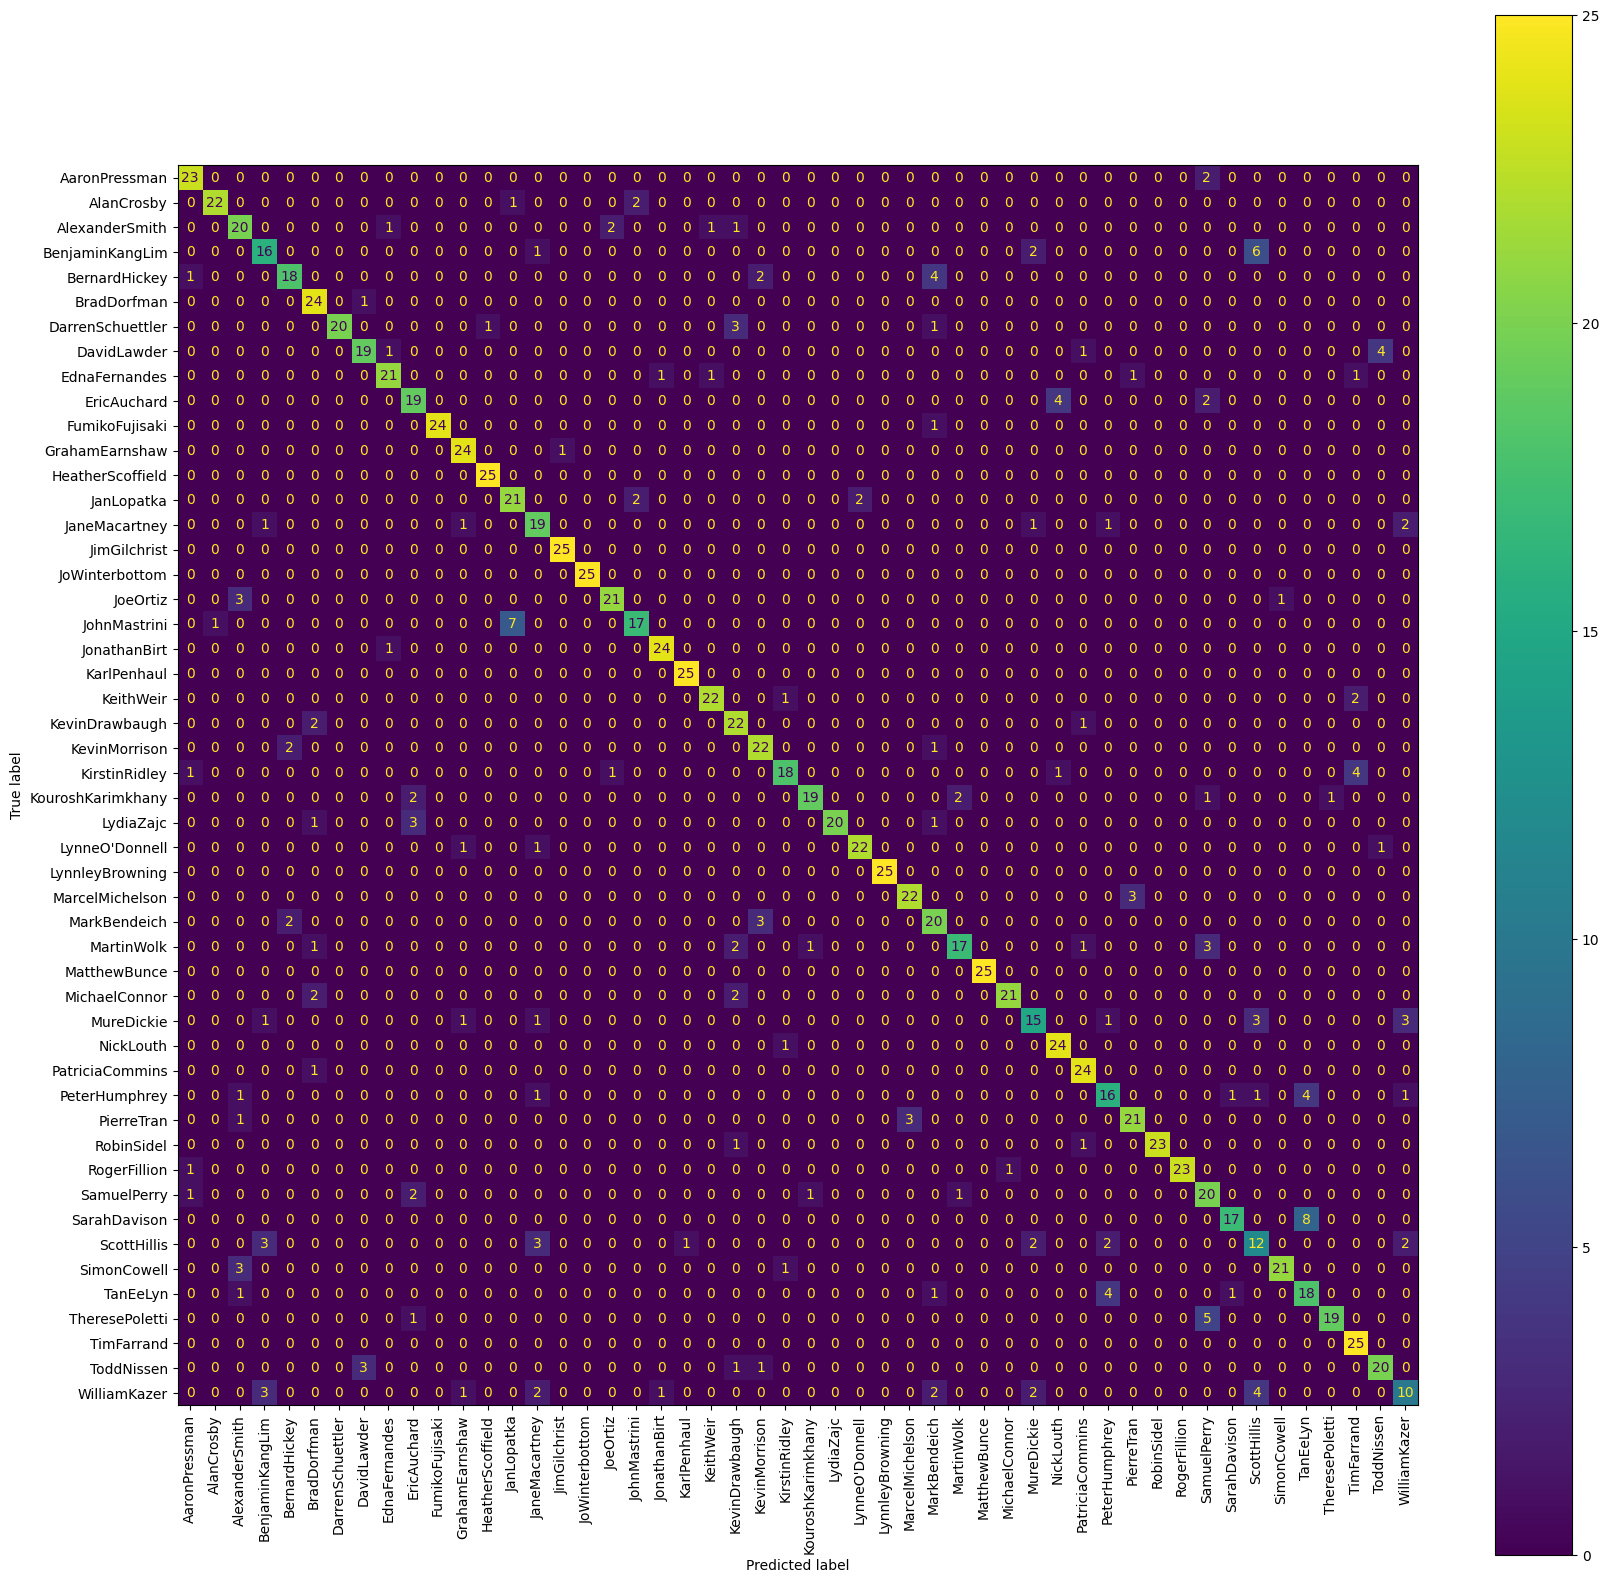

In [182]:
dt_confusion_matrix = confusion_matrix(meaning_y_test, dt_test_predictions)
rf_confusion_matrix = confusion_matrix(meaning_y_test, rf_test_predictions)
svc_confusion_matrix = confusion_matrix(meaning_y_test, svc_test_predictions)

fig, axes = plt.subplots(1,1,figsize=(20,20))
disp = ConfusionMatrixDisplay(dt_confusion_matrix, display_labels = agg_df.index)
disp.plot(ax=axes, xticks_rotation = 'vertical')
plt.show()
fig, axes = plt.subplots(1,1,figsize=(20,20))
disp = ConfusionMatrixDisplay(rf_confusion_matrix, display_labels = agg_df.index)
disp.plot(ax=axes, xticks_rotation = 'vertical')
plt.show()
fig, axes = plt.subplots(1,1,figsize=(20,20))
disp = ConfusionMatrixDisplay(svc_confusion_matrix, display_labels = agg_df.index)
disp.plot(ax=axes, xticks_rotation = 'vertical')
plt.show()

In [183]:
#Ngram SVC Model
ngram_vectorizer = TfidfVectorizer(ngram_range=(1,3))
meaning_X_ngram = meaning_df['text']
meaning_X_ngram = vectorizer.fit_transform(meaning_X_ngram)
meaning_y_ngram = meaning_df['author']

meaning_X_train_ngram, meaning_X_test_ngram, meaning_y_train_ngram, meaning_y_test_ngram = train_test_split(meaning_X_ngram, meaning_y_ngram)

svc_model_ngram = SVC(C=4, gamma=1)
svc_model_ngram.fit(meaning_X_train_ngram, meaning_y_train_ngram)

SVC(C=4, gamma=1)

In [184]:
svc_train_predictions_ngram = svc_model_ngram.predict(meaning_X_train_ngram)
svc_test_predictions_ngram = svc_model_ngram.predict(meaning_X_test_ngram)
svc_train_accuracy_ngram = accuracy_score(meaning_y_train_ngram, svc_train_predictions_ngram)
svc_test_accuracy_ngram = accuracy_score(meaning_y_test_ngram, svc_test_predictions_ngram)
print(svc_train_accuracy_ngram)
print(svc_test_accuracy_ngram)

0.9997333333333334
0.8376


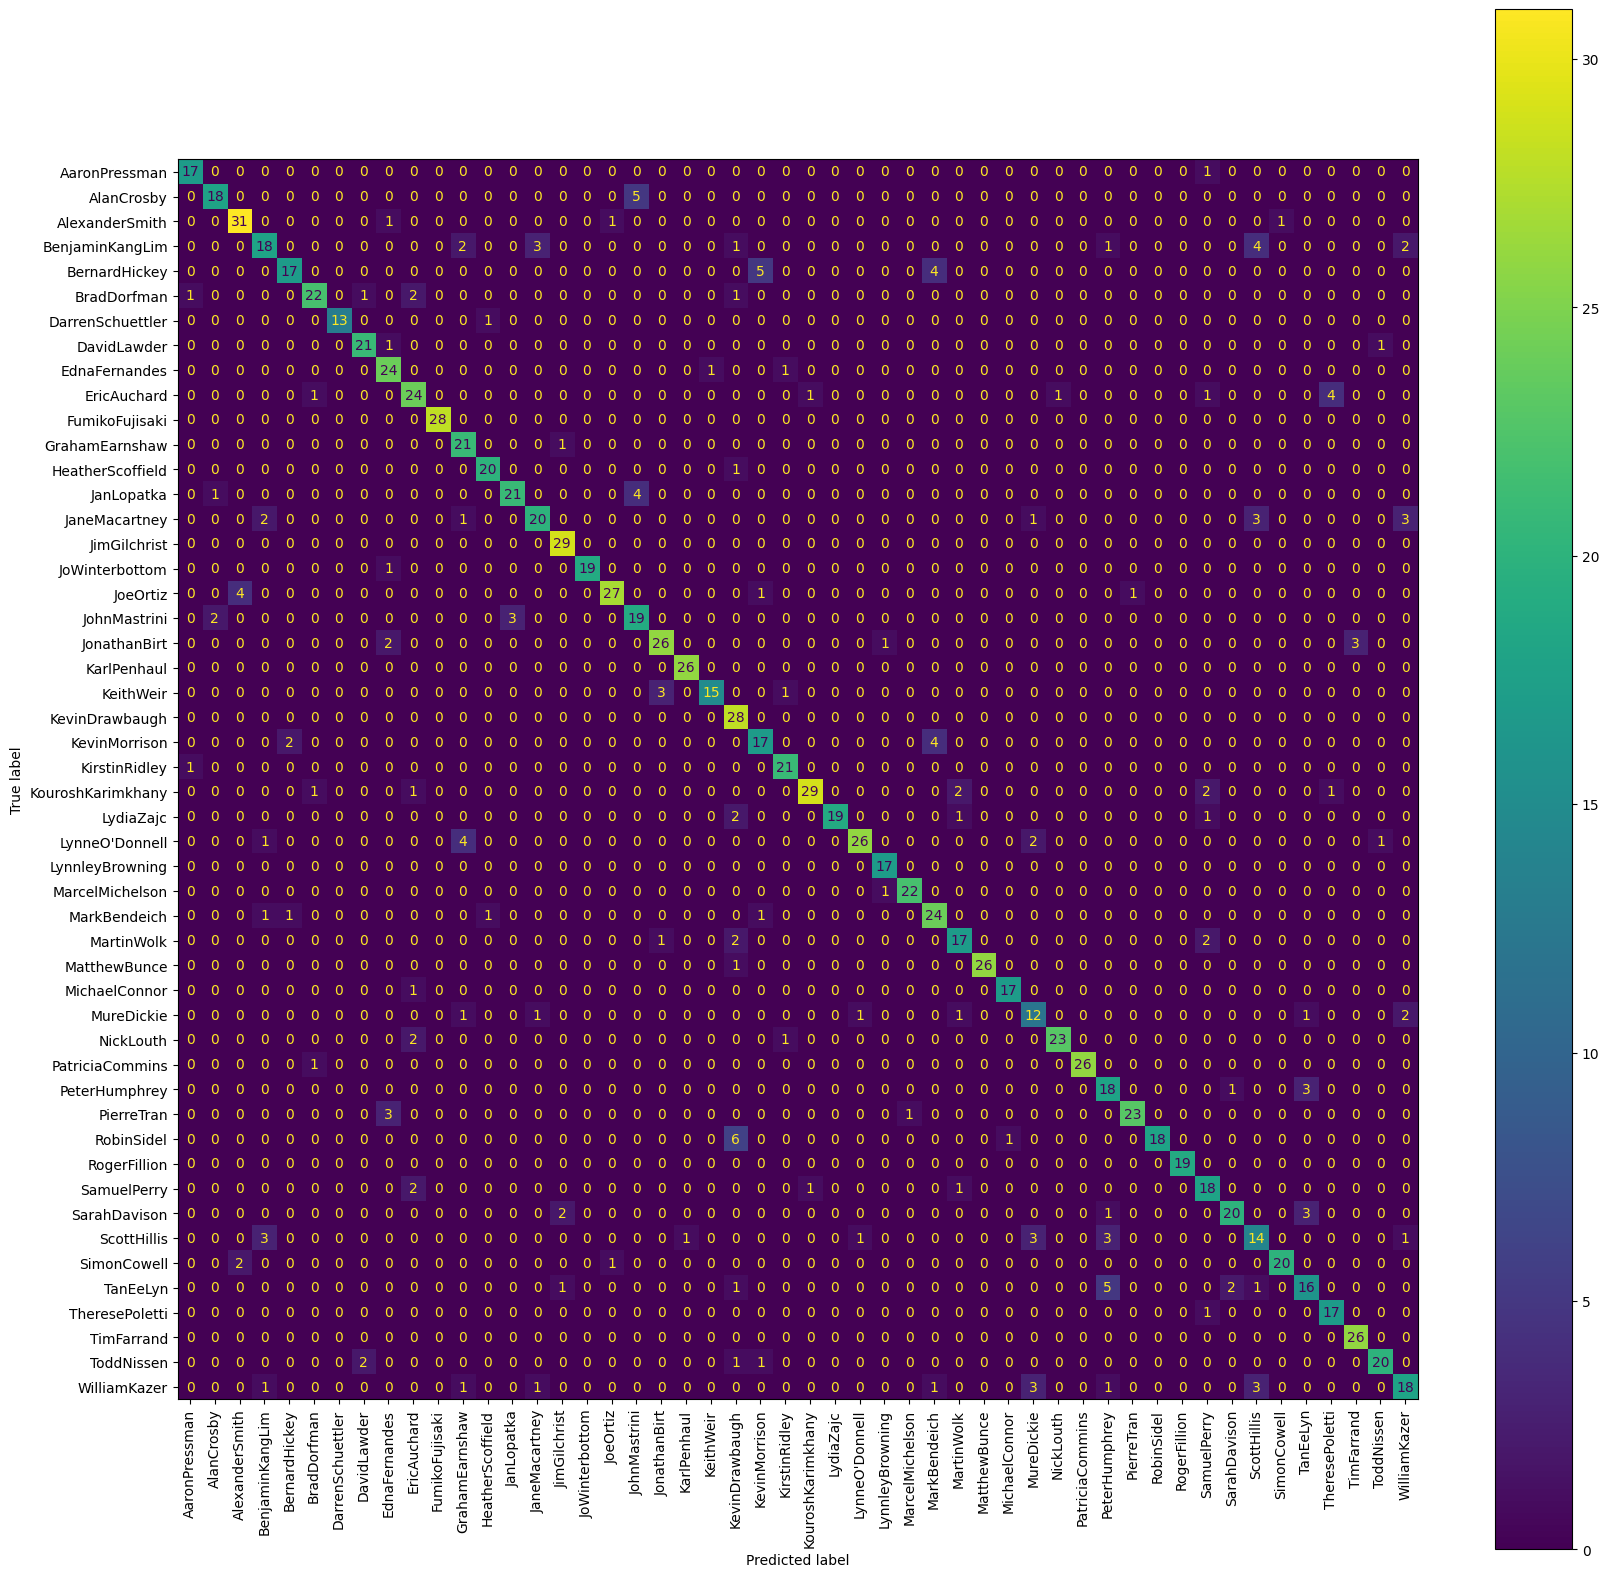

In [185]:
final_confusion_matrix = confusion_matrix(meaning_y_test_ngram, svc_test_predictions_ngram)
fig, axes = plt.subplots(1,1,figsize=(20,20))
disp = ConfusionMatrixDisplay(final_confusion_matrix, display_labels = agg_df.index)
disp.plot(ax=axes, xticks_rotation = 'vertical')
plt.show()

# Discussion and Conclusion #
The best practices for models for topic analysis appear to be relatively effective for author identification, at least in the context of news articles. While an 84% accuracy is not as high as many of the topic identification models, the number of categories when dealing with author identification are much higher, and an 84% accuracy across 50 groups is definitely an effective model. Suprisingly, just vocabulary allowed relatively high accuracy even between authors writing on the same subject, using our previous example we could see that many authors specifically dealt with news on China, but the model still effectively categorized those authors. It appears that word choice alone is sufficient for creating a baseline author model.

Unfortunately because the errors we did see were largely between authors on the same subjects we can conclude that we are losing some style by only considering vocabulary.

For future study, it would be interesting to consider creating another model that did not have access to vocabulary in order to try to group style elements, and then use it collaboratively with this model to identify authors. The model dump is made available in the directory for this future research

In [186]:
import pickle

with open('SVCmodel.pickle','wb') as f:
    pickle.dump(svc_model_ngram,f)